In [150]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from src.features.build_features import MostFrequentImputer, load_data, add_AgeBucket_feature, add_rel_features

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data 

In [2]:
train_data = load_data("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Transform data

## Add new columns

In [3]:
# Calculate relatives on board
relatives = ['SibSp' ,'Parch']
train_data = add_rel_features(train_data,relatives)

In [4]:
# add traveling alone
train_data['traveling_alone'] = np.where(train_data['RelativesOnboard']==0,1,0)

In [5]:
# AgeBucket 
train_data = add_AgeBucket_feature(train_data)

## Pipelines

In [6]:
# numerical pipeline
num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [7]:
# categorical pipeline 
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [8]:
# Full pipeline 
cat_attribs = ["Pclass", "Sex",'Embarked',  'traveling_alone',  'AgeBucket']
num_attribs = [ "RelativesOnboard", "Fare"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

# Test models

In [9]:
# isolating the training labels
y_train = train_data["Survived"]

## KNN classifier 

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=8)

knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()

0.7812563840653729

## SVM

In [10]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7913815117466803

## Random Forrest

In [11]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8081605379639087

## Logistic Regresion 

In [210]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')
log_scores = cross_val_score(log_clf, X_train, y_train, cv=10)
log_scores.mean()

0.8025048235160595

## XGBoost Classifier 

In [129]:
xgb_clf = GradientBoostingClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=10)
xgb_scores.mean()

0.8338905913063217

In [128]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
xgb_scores = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
xgb_scores.mean()


0.8249158249158249

## Plot the Classifiers scores 

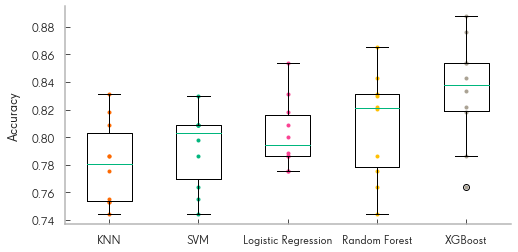

In [152]:
plt.figure(figsize=(8, 4))
models = [ knn_scores, svm_scores,  log_scores ,forest_scores, xgb_scores]

# create scatter points 
for i, model in enumerate( models, start=1): 
    plt.plot([i]*10, model, ".")


plt.boxplot(models, labels=('KNN' , 'SVM', 'Logistic Regression',"Random Forest", 'XGBoost'))
plt.ylabel("Accuracy", fontsize=14)
#plt.xlim(-.5,5.5)
#plt.ylim(.5,1)
plt.show()

# Tune final model 

In [224]:
param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a17f08fd0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a17f08eb8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [225]:
# rename classifier 
xgb_clf = rnd_search.best_estimator_

## inspect hyperparameters

In [155]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('score: \t {}  \t \t {}'.format(round(np.sqrt(-mean_score),4 ) , params))


score: 	 0.4048  	 	 {'max_features': 7, 'n_estimators': 436}
score: 	 0.4103  	 	 {'max_features': 8, 'n_estimators': 189}
score: 	 0.4224  	 	 {'max_features': 5, 'n_estimators': 103}
score: 	 0.4303  	 	 {'max_features': 3, 'n_estimators': 215}
score: 	 0.4034  	 	 {'max_features': 8, 'n_estimators': 373}
score: 	 0.4238  	 	 {'max_features': 4, 'n_estimators': 360}
score: 	 0.413  	 	 {'max_features': 8, 'n_estimators': 131}
score: 	 0.4048  	 	 {'max_features': 6, 'n_estimators': 309}
score: 	 0.4316  	 	 {'max_features': 2, 'n_estimators': 344}
score: 	 0.4062  	 	 {'max_features': 6, 'n_estimators': 386}


In [156]:
# retrieve categorical attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_female',
 'x1_male',
 'x2_C',
 'x2_Q',
 'x2_S',
 'x3_0',
 'x3_1',
 'x4_0.0',
 'x4_15.0',
 'x4_30.0',
 'x4_45.0',
 'x4_60.0',
 'x4_75.0']

In [157]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.08213633, 0.21385599, 0.04028422, 0.02198487, 0.07002705,
       0.21457961, 0.22343942, 0.0045174 , 0.00717143, 0.01248155,
       0.00716714, 0.00508597, 0.06132445, 0.00787803, 0.0092216 ,
       0.0066307 , 0.0093439 , 0.00287033])

In [158]:
trained_columns = num_attribs + cat_attribs_encoded
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.2234394243916987, 'x1_male'),
 (0.21457961044329368, 'x1_female'),
 (0.21385599164496932, 'Fare'),
 (0.08213632697741294, 'RelativesOnboard'),
 (0.07002704956778132, 'x0_3'),
 (0.06132444867780411, 'x4_0.0'),
 (0.04028422272696724, 'x0_1'),
 (0.021984867285771748, 'x0_2'),
 (0.012481551377017104, 'x2_S'),
 (0.009343899056597415, 'x4_60.0'),
 (0.00922160367737021, 'x4_30.0'),
 (0.007878033510366627, 'x4_15.0'),
 (0.00717143080987781, 'x2_Q'),
 (0.007167141760495239, 'x3_0'),
 (0.006630703188425729, 'x4_45.0'),
 (0.005085966095970017, 'x3_1'),
 (0.004517395866672631, 'x2_C'),
 (0.002870332941508296, 'x4_75.0')]

In [162]:
xgb_clf.score(X_train, y_train)

0.9191919191919192

## Model metrics

### ROC curve 

In [174]:
y_probas=xgb_clf.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [175]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

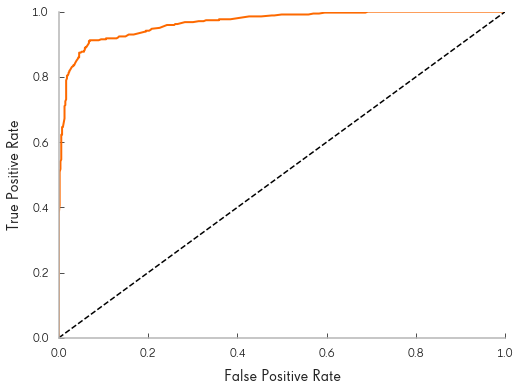

In [176]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()



In [177]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.9667364373289021

In [188]:
precision_score(y_train, y_train_pred)

0.7898089171974523

In [189]:
recall_score(y_train, y_train_pred)

0.7251461988304093

In [186]:
# f1 score 
f1_score(y_train, y_train_pred)

0.7560975609756098

### Precision recall curve

In [178]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

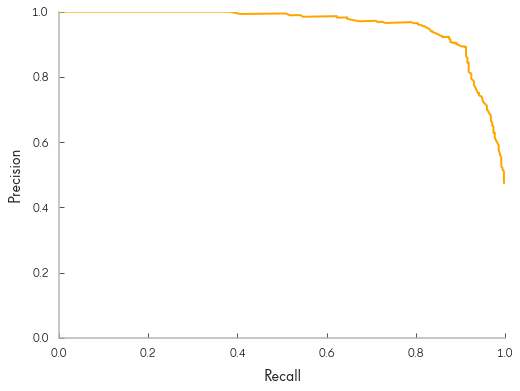

In [184]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Create prediction file 

In [190]:
X_train.shape

(891, 18)

In [193]:
test_data = load_data("test.csv")

In [194]:
len(test_data)

418

In [191]:
# load test data 
from sklearn.externals import joblib
X_test = joblib.load( 'data/processed/X_test.pkl')

In [199]:
test_data['Survived'] = xgb_clf.predict(X_test)

In [206]:
submission = test_data[['PassengerId', 'Survived']]
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [208]:
# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

# Ensemble stacking 

In [253]:
from sklearn.ensemble import VotingClassifier
vote_clf=VotingClassifier(estimators=[ ('rf', forest_clf), ('log', log_clf), ('svm', svm_clf), ('xgb', xgb_clf)], voting='hard')
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [254]:
vote_clf.score(X_train, y_train)

0.8956228956228957

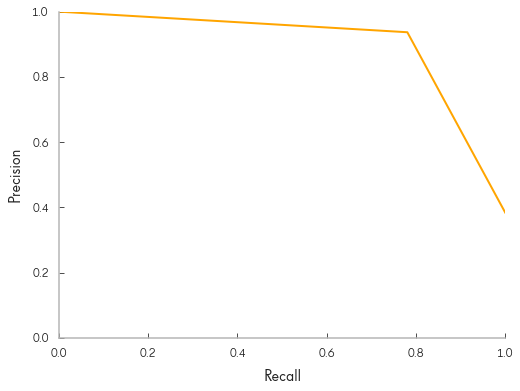

In [255]:
y_scores=vote_clf.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

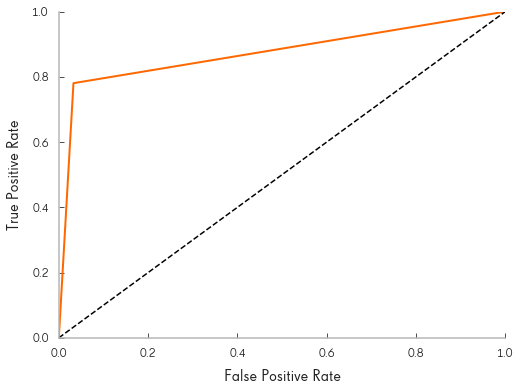

In [256]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [257]:
roc_auc_score(y_train, y_scores)

0.8739574345700316

In [258]:
test_data['Survived'] = vote_clf.predict(X_test)

submission = test_data[['PassengerId', 'Survived']]
submission.head()

# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

In [213]:
# Stack with GMM, use this a new feature generator 

In [261]:
pd.qcut(train_data['Fare'], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
5       (7.91, 14.454]
6      (31.0, 512.329]
7       (14.454, 31.0]
8       (7.91, 14.454]
9       (14.454, 31.0]
10      (14.454, 31.0]
11      (14.454, 31.0]
12      (7.91, 14.454]
13     (31.0, 512.329]
14      (-0.001, 7.91]
15      (14.454, 31.0]
16      (14.454, 31.0]
17      (7.91, 14.454]
18      (14.454, 31.0]
19      (-0.001, 7.91]
20      (14.454, 31.0]
21      (7.91, 14.454]
22      (7.91, 14.454]
23     (31.0, 512.329]
24      (14.454, 31.0]
25     (31.0, 512.329]
26      (-0.001, 7.91]
27     (31.0, 512.329]
28      (-0.001, 7.91]
29      (-0.001, 7.91]
            ...       
861     (7.91, 14.454]
862     (14.454, 31.0]
863    (31.0, 512.329]
864     (7.91, 14.454]
865     (7.91, 14.454]
866     (7.91, 14.454]
867    (31.0, 512.329]
868     (7.91, 14.454]
869     (7.91, 14.454]
870     (-0.001, 7.91]
871    (31.0, 512.329]
872     (-0.001, 7.91]
873     (7.